In [0]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, from_json, split, regexp_replace, when, size,
    from_unixtime, expr, date_format, to_timestamp, lit
)
from pyspark.sql.types import StructType, StructField, StringType
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [0]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("JSONImport") \
    .master("local[*]") \
    .getOrCreate()

In [0]:
# Specify the path to your JSON file
file_path = "/FileStore/tables/cc_sample_transaction.json"

In [0]:
# Read JSON file into a DataFrame
df = spark.read.json(file_path)

In [0]:
# Define schemas for nested JSON structures
address_schema = StructType([
    StructField("street", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip", StringType(), True)
])

personal_detail_schema = StructType([
    StructField("person_name", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True),
    StructField("lat", StringType(), True),
    StructField("long", StringType(), True),
    StructField("city_pop", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", StringType(), True)
])

In [0]:
# Display the original DataFrame
print("Original DataFrame:")
df.show(n=100, truncate=False)
df.printSchema()

Original DataFrame:
+----------+------+-------------+-----------+-------------------+--------+----------------+----------------------+------------------+------------------+-------------+-------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+--------------------------------+
|Unnamed: 0|amt   |category     |cc_bic     |cc_num             |is_fraud|merch_eff_time  |merch_last_update_time|merch_lat         |merch_long        |merch_zipcode|merchant                                   |personal_detail                                                                                                                                                                                                      

In [0]:
# First level flattening - personal_detail
df_level1 = df.select(
    *[col(field.name) for field in df.schema.fields if field.name != "personal_detail"],
    from_json(col("personal_detail"), personal_detail_schema).alias("personal_detail_struct")
)

In [0]:
# Extract all fields from personal_detail_struct
df_level2 = df_level1.select(
    *[col(field.name) for field in df_level1.schema.fields if field.name != "personal_detail_struct"],
    col("personal_detail_struct.person_name").alias("person_name"),
    col("personal_detail_struct.gender").alias("gender"),
    col("personal_detail_struct.address").alias("address_json"),
    col("personal_detail_struct.lat").alias("lat"),
    col("personal_detail_struct.long").alias("long"),
    col("personal_detail_struct.city_pop").alias("city_pop"),
    col("personal_detail_struct.job").alias("job"),
    col("personal_detail_struct.dob").alias("dob")
)

In [0]:
# Flatten address and clean person_name
df_level3 = df_level2.select(
    *[col(field.name) for field in df_level2.schema.fields if field.name != "address_json"],
    from_json(col("address_json"), address_schema).alias("address_struct")
).select(
    *[col(field.name) for field in df_level2.schema.fields if field.name != "address_json"],
    col("address_struct.street").alias("street"),
    col("address_struct.city").alias("city"),
    col("address_struct.state").alias("state"),
    col("address_struct.zip").alias("zip")
)

In [0]:
# Clean person_name and split into first and last names
cleaned_df = df_level3.withColumn(
    "person_name",
    regexp_replace(
        regexp_replace(
            regexp_replace(col("person_name"), 
                           "[!@#$%^&*()|/]", " "  # Replace specific unwanted special characters with space
            ),
            "[,]+", " "  # Replace commas with space
        ),
        "\\s+", " "  # Replace multiple spaces with a single space
    )
)

In [0]:
# Convert timestamp columns to human-readable format in UTC+8
timestamp_df = cleaned_df \
    .withColumn(
        "trans_date_trans_time",
        date_format(to_timestamp(col("trans_date_trans_time")), "yyyy-MM-dd HH:mm:ss.SSSSSS 'UTC+8'")
    ) \
    .withColumn(
        "merch_last_update_time",
        date_format(
            from_unixtime(col("merch_last_update_time").cast("double") / 1000), 
            "yyyy-MM-dd HH:mm:ss.SSSSSS 'UTC+8'"
        )
    ) \
    .withColumn(
        "merch_eff_time",
        date_format(
            from_unixtime(col("merch_eff_time").cast("double") / 1000000), 
            "yyyy-MM-dd HH:mm:ss.SSSSSS 'UTC+8'"
        )
    )

In [0]:
# Split person_name into first and last names
final_df = timestamp_df.withColumn("name_parts", split(col("person_name"), "\\s+")) \
    .withColumn("first", col("name_parts")[0]) \
    .withColumn("last", when(size(col("name_parts")) > 1, 
                             expr("trim(name_parts[1])"))  # Trim to handle leading/trailing spaces
                   .otherwise(None)) \
    .withColumn(
        "cc_bic",
        when(
            (col("cc_bic") == "") | 
            (col("cc_bic").isin("Null", "NA")), 
            lit("NULL")
        ).otherwise(col("cc_bic"))
    ) \
    .select(
        "Unnamed: 0",
        "trans_date_trans_time",
        "cc_num",
        "merchant",
        "category",
        "amt",
        "first",
        "last",
        "gender",
        "street",
        "city",
        "state",
        "zip",
        "lat",
        "long",
        "city_pop",
        "job",
        "dob",
        "trans_num",
        "merch_lat",
        "merch_long",
        "is_fraud",
        "merch_zipcode",
        "merch_last_update_time",
        "merch_eff_time",
        "cc_bic"
    ) \
    .withColumn("amt", col("amt").cast("float"))  # Convert amt to float

In [0]:
# Show the final DataFrame with all rows displayed
print("Final Flattened DataFrame:")
final_df.show(n=100, truncate=False)
final_df.printSchema()

Final Flattened DataFrame:
+----------+--------------------------------+-------------------+-------------------------------------------+-------------+------+-----------+----------+------+-------------------------------+------------------------+-----+-----+-------+------------------+--------+---------------------------------------------+----------+--------------------------------+------------------+------------------+--------+-------------+--------------------------------+--------------------------------+-----------+
|Unnamed: 0|trans_date_trans_time           |cc_num             |merchant                                   |category     |amt   |first      |last      |gender|street                         |city                    |state|zip  |lat    |long              |city_pop|job                                          |dob       |trans_num                       |merch_lat         |merch_long        |is_fraud|merch_zipcode|merch_last_update_time          |merch_eff_time               

In [0]:
# Specify the output path
output_path = os.path.join(os.getcwd(), "/FileStore/tables/Output.csv")

# Write final DataFrame to CSV
final_df.write.mode("overwrite").option("header", "true").csv("/dbfs/" + output_path)
print(f"Data saved to {output_path}")

Data saved to /FileStore/tables/Output.csv


In [0]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = final_df.toPandas()

In [0]:
# Visualization
sns.set(style="whitegrid")

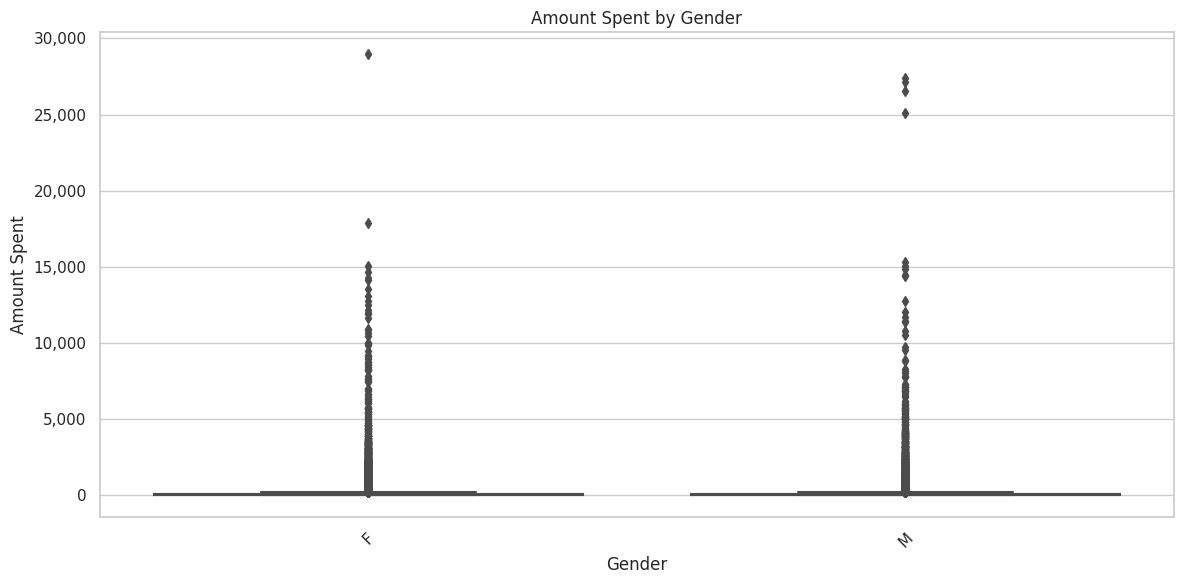

In [0]:
# Define the formatter function
def millions_formatter(x, pos):
    return f'{int(x):,}'

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='gender', y='amt', data=pandas_df)

# Apply the formatter to y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.title('Amount Spent by Gender')
plt.xlabel('Gender')
plt.ylabel('Amount Spent')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts the plot to ensure labels fit
plt.show()

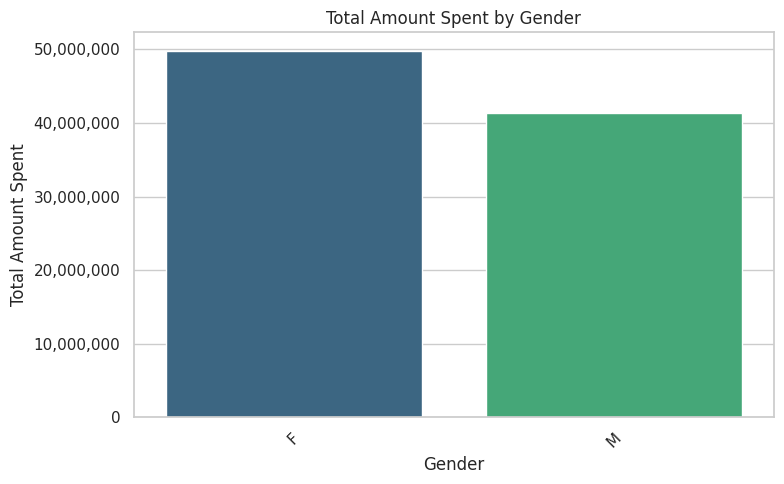

In [0]:
# Alternatively, create a bar plot for the total amount spent by gender
total_amt_by_gender = pandas_df.groupby('gender')['amt'].sum().reset_index()

# Define the formatter function
def millions_formatter(x, pos):
    return f'{int(x):,}'

# Create the barplot
plt.figure(figsize=(8, 5))
sns.barplot(x='gender', y='amt', data=total_amt_by_gender, palette='viridis')

# Apply the formatter to y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.title('Total Amount Spent by Gender')
plt.xlabel('Gender')
plt.ylabel('Total Amount Spent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [0]:
# When stopping, use this order:
def clean_spark_stop():
    try:
        spark.sparkContext.stop()
        spark.stop()
        print("Spark stopped successfully")
    except Exception as e:
        print(f"Error stopping Spark: {e}")
        # Force stop on Windows
        if os.name == 'nt':
            os.system('taskkill /f /im java.exe')